## Different methods explored to classify text

In this notebook I will demonstrate 3 different ways how we can classify text into categories:
1. Using word vectors and aggregating them to sentence levels we end up with a matrix of (len(n) x len(vector)) on top of which any ML algo can be applied
2. Using the same amount of word vectors in each sentence we can apply an Embedding layer in DL
3. Enhancing #2 with LSTM layers to introduce 'context' of text into the modeling


I will use the sklearn news groups built in dataset for modeling and limit my labels to 3

In [144]:
from sklearn.datasets import fetch_20newsgroups

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
data = fetch_20newsgroups(subset = 'all', remove = ('headers', 'footers', 'quotes'),
                          categories = ['comp.graphics', 'rec.sport.baseball', 'sci.med'])

texts, labels = data.data, data.target

print('Amount of texts to classify:', len(texts))
print('Amount of labels corresponding to texts:', len(labels))

Amount of texts to classify: 2957
Amount of labels corresponding to texts: 2957


In [23]:
print('0 = computers, 1 = baseball, 2 = medicie')
np.unique(labels, return_counts = True)

0 = computers, 1 = baseball, 2 = medicie


(array([0, 1, 2], dtype=int64), array([973, 994, 990], dtype=int64))

In [26]:
print('Here is an example of a computer text:')
print(texts[1])

print('\nHere is a baseball text:')
print(texts[2])

print('\nHere is a medicie related text:')
print(texts[0])

Here is an example of a computer text:



It is for a business and the end product has to be a photograph.
I take damaged black and whites, usually old, some very, and repair them
by hand at present.  I would like to do this by using a computer.
I am just trying to find a vendor who can convert my computer stored
images to negatives or thermal print.  The customer will want his/her
copy as much as possible like a brand new original photgraph.


-- David

Here is a baseball text:


But of course, it is expected that umpires will show up players.

Don't get me wrong, I understand the nature of the game, but I just 
believe that a little ego-ectomy for the umpires would make the game 
much better.

Ted

--
"Social nags and body bags, make you dead, what a drag drag drag."
-- Saigon Kick, body bags, The Lizard               

Here is a medicie related text:



Is that true?  I know some that won't even interview FMGs.  
Most programs discriminate, in that given an FMG equally
qualified as 

### First things first - cleaning the text

1. Remove footers (everything after the -- sign)
2. Lowercase
3. Remove numbers and punctuation
4. Remove stopwords
5. Lemmatize
6. Check if there are 'empty' strings left

In [50]:
import re
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

In [45]:
def text_cleaner(text):
    
    text = text.split('--', 1)[0]
    text = text.lower()
    text = re.sub('\d+', '', text)
    text = ' '.join([word for word in text.split() if word not in (stopwords.words('english'))])
    text = re.compile('[^a-z]').sub(' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip()
    
    return text

In [47]:
texts_clean = [text_cleaner(text) for text in texts]

In [48]:
print('Here is the clean computer text from before:')
print(texts_clean[1])

print('\nHere is the cleaned baseball text:')
print(texts_clean[2])

print('\nAnd here is the medicie related text, after cleaning:')
print(texts_clean[0])

Here is the clean computer text from before:
business end product photograph take damaged black whites usually old very repair hand present would like using computer trying find vendor convert computer stored images negatives thermal print customer want his her copy much possible like brand new original photgraph

Here is the cleaned baseball text:
course expected umpires show players get wrong understand nature game believe little ego ectomy umpires would make game much better ted

And here is the medicie related text, after cleaning:
true know even interview fmgs programs discriminate given fmg equally qualified american take american rights actually have matter us citizens most not good luck fmgs bad luck best residents fmgs also worst turns out worst fmgs often us citizens studied off shore medical schools residents fired incompetence years i ve department fmgs us citizens studied guadalajara us citizen trained soviet union one philipina unfortunately practicing medicine somewhere 

#### Apply lemmatization to reduce cardinality

In [51]:
def nltk_tag_to_wordnet_tag(nltk_tag):
    
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(sentence):
    
    nltk_tagged = pos_tag(word_tokenize(sentence))  
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    
    lemmatized_sentence = []    
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:        
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
            
    return " ".join(lemmatized_sentence)

In [55]:
lemmatizer = WordNetLemmatizer()
texts_lemmatized = [lemmatize_sentence(text) for text in texts_clean]

In [58]:
print('Here is the lemmatized computer text from before:')
print(texts_lemmatized[1])

print('\nHere is the lemmatized baseball text:')
print(texts_lemmatized[2])

print('\nAnd here is the medicie related text, after lemmatization:')
print(texts_lemmatized[0])

Here is the lemmatized computer text from before:
business end product photograph take damage black white usually old very repair hand present would like use computer try find vendor convert computer store image negative thermal print customer want his her copy much possible like brand new original photgraph

Here is the lemmatized baseball text:
course expect umpires show player get wrong understand nature game believe little ego ectomy umpire would make game much well ted

And here is the medicie related text, after lemmatization:
true know even interview fmgs program discriminate give fmg equally qualified american take american right actually have matter us citizens most not good luck fmgs bad luck best resident fmgs also worst turn out bad fmgs often us citizen study off shore medical school resident fire incompetence year i ve department fmgs us citizens study guadalajara us citizen train soviet union one philipina unfortunately practice medicine somewhere neurology picked progra

In [66]:
removed_everything = []

for i, text in enumerate(texts_lemmatized):
    if len(text) == 0:
        removed_everything.append(i)

print('Will have to drop these text-label pairs:\n')
print(removed_everything)

Will have to drop these text-label pairs:

[10, 38, 109, 114, 158, 167, 266, 290, 293, 308, 331, 350, 352, 438, 455, 466, 532, 550, 587, 594, 599, 635, 689, 699, 707, 739, 740, 752, 771, 788, 803, 809, 863, 884, 900, 905, 978, 1009, 1029, 1075, 1106, 1113, 1119, 1128, 1132, 1171, 1182, 1247, 1250, 1258, 1261, 1275, 1311, 1314, 1333, 1373, 1413, 1421, 1444, 1472, 1485, 1561, 1652, 1664, 1669, 1744, 1784, 1820, 1842, 1885, 1902, 1905, 1906, 1914, 1918, 1933, 1953, 1960, 1996, 2009, 2025, 2068, 2081, 2138, 2157, 2161, 2176, 2191, 2197, 2200, 2211, 2233, 2238, 2258, 2285, 2341, 2345, 2411, 2437, 2474, 2492, 2494, 2499, 2508, 2511, 2529, 2551, 2560, 2568, 2573, 2579, 2592, 2666, 2748, 2758, 2771, 2783, 2789, 2827, 2849, 2858]


In [114]:
data = pd.DataFrame(labels, texts_clean).reset_index().rename(columns = {'index' : 'text', 0 : 'label'})
data = data[data['text'] != '']
data.head()

,text,label
0,true know even interview fmgs programs discrim...,2
1,business end product photograph take damaged b...,0
2,course expected umpires show players get wrong...,1
3,essential tremor progressive hereditary tremor...,2
4,in article apr locus com michael trofimoff wou...,2


In [119]:
texts_final = data['text'].tolist()
labels = data['label'].tolist()

### Use Google's word2vec word embedding vectors 

<img src='https://lionbridge.ai/wp-content/uploads/2020/03/2020-03-27_end-to-end-multiclass.jpg' width=700>

#### Drop words from text that are not represented in Google's word2vec model containing 3 million different words

This will get rid of
- typos
- foreign words
- words without meaning
- very specific words, abbreviations

In [120]:
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

In [121]:
EMBEDDING_FILE = '../GoogleNews-vectors-negative300.bin.gz'
google_word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary = True)

In [133]:
clean_texts = []

for text in texts_final:
    clean_text = ' '.join([word for word in text.split() if word in google_word2vec.vocab])
    clean_texts.append(clean_text)
    
print(len(texts_final))
print(len(clean_texts))

2836
2836


In [134]:
removed_everything = []

for i, text in enumerate(clean_texts):
    if len(text) == 0:
        removed_everything.append(i)

print('Will have to drop these text-label pairs:\n')
print(removed_everything)

Will have to drop these text-label pairs:

[593]


In [137]:
data = pd.DataFrame(labels, clean_texts).reset_index().rename(columns = {'index' : 'text', 0 : 'label'})
data[data['text'] == '']

,text,label
593,,1


In [138]:
data = data[data['text'] != '']

texts_final = data['text'].tolist()
labels = data['label'].tolist()

len(texts_final) == len(labels)

True

We are done with the data cleaning, now we can explore our texts' lenghts, because when we do option #2 (word embeddings in neural net layers) we'll have to pad our sentences, so that they are of the same length (each comment is limited to let's say 50 words)

### Text lenghts

In [142]:
data['text_length'] = data['text'].apply(lambda x: len(x.split()))

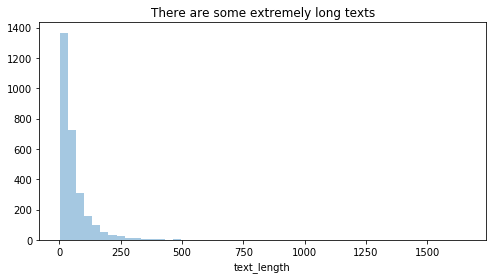

In [148]:
plt.figure(figsize = (8, 4))
sns.distplot(data['text_length'], kde = False)
plt.title('There are some extremely long texts')
plt.show()

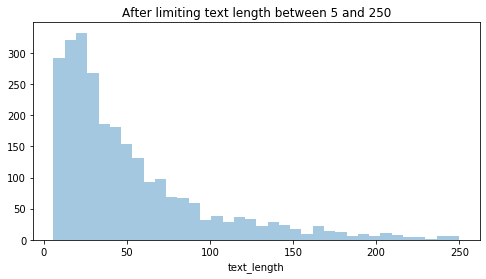

In [160]:
data = data[data['text_length'] <= 250]
data = data[data['text_length'] > 5]

plt.figure(figsize = (8, 4))
sns.distplot(data['text_length'], kde = False)
plt.title('After limiting text length between 5 and 250')
plt.show()

This should be fine, the average text length is around 50 words, the median is about 35. For sentence embeddings I will just average the word embeddings, for neural nets with Embedding() layers I will pad the sequences.

In [163]:
data.to_csv('data/fetch20_cleaned.csv', index = False)

## Classifications

### Method #1: averaging word embedding vectors on sentence levels

After that I can use the resulting vectors as input to any ML model

#### 1. Assign each word its vector from Google word2vec

In [164]:
word_vectors_by_text = []

for line in texts_final:    
    vectors = []
    
    for word in line.split():        
        vectors.append(google_word2vec[word])
                
        # if word not in google_word2vec.vocab:
        #     vectors.append(np.zeros(300))
        # else:
        
    word_vectors_by_text.append(vectors)

#### 2. Calculate 'mean' vector for each sentence

In [167]:
avg_vectors = []

for vectors in word_vectors_by_text:    
    n = len(vectors)
    N = np.zeros(300)
    
    for vector in vectors:        
        N += vector
        
    avg_vector = N / n    
    avg_vectors.append(avg_vector)

#### 3. Resulting array has 300 vectors for each one of the 2835 texts

In [183]:
X = np.array(avg_vectors)
X.shape

(2835, 300)

### Let's take a moment and try to visualize the texts by their labels in reduced dimensions

In [182]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Principal Component Analysis

In [212]:
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X)

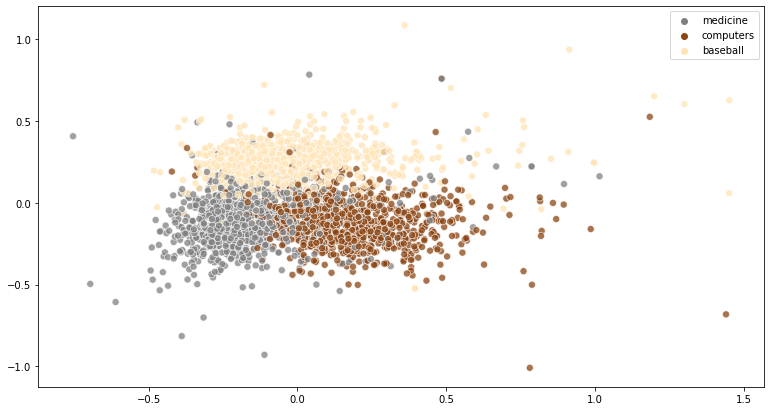

In [239]:
mapper = {0 : 'computers', 1 : 'baseball', 2 : 'medicine'}
labels_decoded = [mapper[k] for k in labels]

plt.figure(figsize = (13, 7))
sns.scatterplot(x = X_pca[:,0], y = X_pca[:,1], s = 50, hue = labels_decoded, alpha = 3/4, palette = {'medicine' : 'gray', 'computers' : 'saddlebrown', 'baseball' : 'moccasin'})
plt.show()

t-SNE

In [241]:
X_tsne = TSNE(n_components = 2, verbose = 1).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2835 samples in 0.215s...
[t-SNE] Computed neighbors for 2835 samples in 5.167s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2835
[t-SNE] Computed conditional probabilities for sample 2000 / 2835
[t-SNE] Computed conditional probabilities for sample 2835 / 2835
[t-SNE] Mean sigma: 0.171852
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.435333
[t-SNE] KL divergence after 1000 iterations: 1.982912


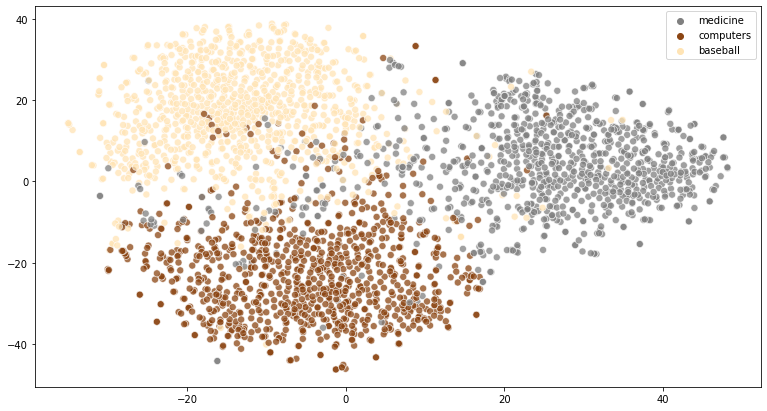

In [242]:
plt.figure(figsize = (13, 7))
sns.scatterplot(x = X_tsne[:,0], y = X_tsne[:,1], s = 50, hue = labels_decoded, alpha = 3/4, palette = {'medicine' : 'gray', 'computers' : 'saddlebrown', 'baseball' : 'moccasin'})
plt.show()

It looks like using word2vec word vectors and averaging them on sentence levels created features that can separate the datapoints pretty well